# Relearning Policy with Supervised Learning

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

import tensorflow as tf
import gym

from spinup.algos.vd3_delayed_dropout import core
from spinup.algos.vd3_delayed_dropout.core import get_vars
from spinup.algos.vd3_delayed_dropout.investigate_uncertainty import UncertaintyModule


import c:\users\pc-admin\github repos\spinningup\spinup\algos\vd3_delayed_dropout\core.py


## Load Data

In [2]:

# Load configuration
config_file_path = r"C:\Users\pc-admin\Github Repos\spinningup\data\2019-04-03_ud3_test_experience_saving\2019-04-03_22-43-40-ud3_test_experience_saving_s3\config.json"
with open(config_file_path) as config_file:
    config = json.load(config_file)

# Load experiences
experience_file_path = r"C:\Users\pc-admin\Github Repos\spinningup\data\2019-04-04_ud3_test_experience_saving\2019-04-04_00-17-28-ud3_test_experience_saving_s3\experiences.txt"
experience_df = pd.read_csv(experience_file_path, sep='\t')

# Load uncertainty change record
uncertainty_file_path = r"C:\Users\pc-admin\Github Repos\spinningup\data\2019-04-04_ud3_test_experience_saving\2019-04-04_00-17-28-ud3_test_experience_saving_s3\uncertainty.txt"
uncertainty_df = pd.read_csv(uncertainty_file_path,  sep='\t')

# Load sampled observations
sample_obs_file_path = r"C:\Users\pc-admin\Github Repos\spinningup\data\2019-04-04_ud3_test_experience_saving\2019-04-04_00-17-28-ud3_test_experience_saving_s3\sample_observation.txt"
sample_obs_df = pd.read_csv(sample_obs_file_path,  sep='\t')

# Load epoch record
progress_file_path = r"C:\Users\pc-admin\Github Repos\spinningup\data\2019-04-04_ud3_test_experience_saving\2019-04-04_00-17-28-ud3_test_experience_saving_s3\progress.txt"
progress_df = pd.read_csv(progress_file_path,  sep='\t')


### Restore hyper-parameters

In [3]:
seed = config['seed']
n_post_q = config['n_post_q']
batch_size = config['batch_size']
steps_per_epoch = config['steps_per_epoch']
epochs = config['epochs']

replay_size = config['replay_size']
max_ep_len = config['max_ep_len']

ac_kwargs = config['ac_kwargs']
dropout_rate=config['dropout_rate']
noise_clip = config['noise_clip']

gamma = config['gamma']
pi_lr = config['pi_lr']
q_lr = config['q_lr']
polyak = config['polyak']

target_policy_smooth = config['target_policy_smooth']
target_noise = config['target_noise']

In [4]:
obs_dim = 17
act_dim = 6


### Put experience into ReplayBuffer

In [5]:
class ReplayBuffer:
    """
    A simple FIFO experience replay buffer for TD3 agents.
    """

    def __init__(self, obs_dim, act_dim, size, max_ep_len):
        self.obs1_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.obs2_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size, act_dim], dtype=np.float32)
        self.rews_buf = np.zeros(size, dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.q_targ_buf = np.zeros(size, dtype=np.float32)
        self.ptr, self.size, self.max_size, self.max_ep_len = 0, 0, size, max_ep_len

    def store(self, obs, act, rew, next_obs, done):
        self.obs1_buf[self.ptr] = obs
        self.obs2_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr+1) % self.max_size
        self.size = min(self.size+1, self.max_size)

    def sample_batch(self, batch_size=32, boundary=None):
        if boundary is None:
            idxs = np.random.randint(0, self.size, size=batch_size)
        else:
            idxs = np.random.randint(0, boundary, size=batch_size)
        return dict(obs1=self.obs1_buf[idxs],
                    obs2=self.obs2_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs],
                    q_targ=self.q_targ_buf[idxs])
    
    def sample_batch_rollout(self, batch_size=32):
        idxs = np.random.randint(0, self.size-self.max_ep_len, size=batch_size)
        return dict(obs1=self.obs1_buf[idxs],
                    obs2=self.obs2_buf[idxs],
                    acts=self.acts_buf[idxs],
                    rews=self.rews_buf[idxs],
                    done=self.done_buf[idxs],
                    q_targ=self.q_targ_buf[idxs])
    
    def generate_target_q(self):
        ### Generate true Q(s,a) from experience trojectory
        # No rollout for last episode
        for i in range(self.size-self.max_ep_len):
            o1 = self.obs1_buf[i]
            a = self.acts_buf[i]
            r = self.rews_buf[i]
            o2 = self.obs2_buf[i]
            d = self.done_buf[i]
            q_targ_backup = 0
            for rollout_i in range(i, i+self.max_ep_len):
                q_targ_backup += self.rews_buf[rollout_i]
                if self.done_buf[rollout_i]:
                    break
            self.q_targ_buf[i] = q_targ_backup
    
replay_buffer = ReplayBuffer(obs_dim=obs_dim, act_dim=act_dim, size=replay_size, max_ep_len=max_ep_len)

replay_buffer.size = experience_df.shape[0]
replay_buffer.obs1_buf = experience_df.iloc[:,2:2+obs_dim].copy().values
replay_buffer.acts_buf = experience_df.iloc[:,2+obs_dim:2+obs_dim+act_dim].copy().values
replay_buffer.rews_buf = np.squeeze(experience_df.iloc[:,2+obs_dim+act_dim:2+obs_dim+act_dim+1].copy().values)
replay_buffer.obs2_buf = experience_df.iloc[:,2+obs_dim+act_dim+1:2+obs_dim+act_dim+1+obs_dim].copy().values
replay_buffer.done_buf = np.squeeze(experience_df.iloc[:,2+obs_dim+act_dim+1+obs_dim:2+obs_dim+act_dim+1+obs_dim+1].copy().values)

# replay_buffer.generate_target_q()

In [6]:
# experience_df.columns[2:2+obs_dim]
# experience_df.columns[2+obs_dim:2+obs_dim+act_dim]
# experience_df.columns[2+obs_dim+act_dim:2+obs_dim+act_dim+1]
# experience_df.columns[2+obs_dim+act_dim+1:2+obs_dim+act_dim+1+obs_dim]
# experience_df.columns[2+obs_dim+act_dim+1+obs_dim:2+obs_dim+act_dim+1+obs_dim+1]
# print(replay_buffer.obs1_buf.shape)
# print(replay_buffer.acts_buf.shape)
# print(replay_buffer.rews_buf.shape)
# print(replay_buffer.obs2_buf.shape)
# print(replay_buffer.done_buf.shape)
replay_buffer.obs1_buf[[1,2,3]].shape

(3, 17)

<IPython.core.display.Javascript object>


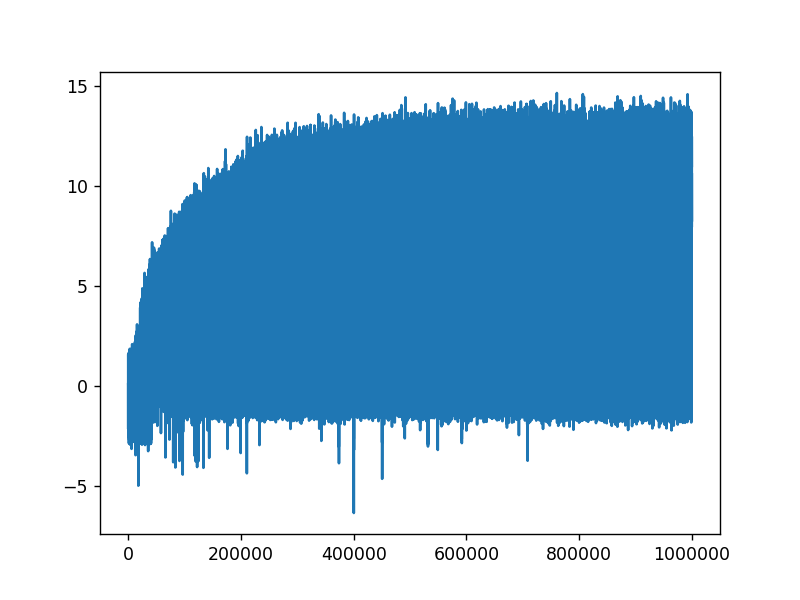

In [7]:
plt.figure()
plt.plot(np.arange(len(replay_buffer.rews_buf)),replay_buffer.rews_buf)

In [8]:
# from sklearn.neighbors import KDTree
# X = replay_buffer.obs1_buf
# kdt = KDTree(X, leaf_size=30, metric='euclidean')

# from sklearn.neighbors import NearestNeighbors
# X = replay_buffer.obs1_buf
# nbrs = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(X)
# nbrs.kneighbors_graph(X).toarray()

## Create Actor-Critic

In [15]:
tf.reset_default_graph()
actor_critic=core.mlp_actor_critic
tf.set_random_seed(seed)
np.random.seed(seed)

def env_fn():
    return gym.make('HalfCheetah-v2')
env, test_env = env_fn(), env_fn()
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]

# Action limit for clamping: critically, assumes all dimensions share the same bound!
act_limit = env.action_space.high[0]

# Share information about action space with policy architecture
ac_kwargs['action_space'] = env.action_space

# Create policy
# Inputs to computation graph
x_ph, a_ph, x2_ph, r_ph, d_ph = core.placeholders(obs_dim, act_dim, obs_dim, None, None)

# Main outputs from computation graph
with tf.variable_scope('main'):
    pi, pi_reg, pi_dropout_mask_generator, pi_dropout_mask_phs,\
    q, q_reg, q_dropout_mask_generator, q_dropout_mask_phs,\
    q_pi, q_pi_reg = actor_critic(x_ph, a_ph, **ac_kwargs, dropout_rate=dropout_rate)

# Target policy network
with tf.variable_scope('target'):
    pi_targ, _, pi_targ_dropout_mask_generator, pi_dropout_mask_phs_targ, \
    q_targ, _, q_targ_dropout_mask_generator, q_dropout_mask_phs_targ, q_pi_targ, _  = actor_critic(x2_ph, a_ph, **ac_kwargs, dropout_rate=dropout_rate)

# # Target policy network
# with tf.variable_scope('target'):
#     pi_targ, _, pi_targ_dropout_mask_generator, pi_dropout_mask_phs_targ, \
#     _, _, _, _, _, _ = actor_critic(x2_ph, a_ph, **ac_kwargs, dropout_rate=dropout_rate)

# # Target Q networks
# with tf.variable_scope('target', reuse=True):
#     target_policy_smooth = True
#     if target_policy_smooth == True:
#         # Target policy smoothing, by adding clipped noise to target actions
#         epsilon = tf.random_normal(tf.shape(pi_targ), stddev=target_noise)
#         epsilon = tf.clip_by_value(epsilon, -noise_clip , noise_clip )
#         a2 = pi_targ + epsilon
#         a2 = tf.clip_by_value(a2, -act_limit, act_limit)
#     else:
#         a2 = pi_targ
    
#     # Target Q-values, using action from target policy
#     _, _, _, pi_dropout_mask_phs_targ2, \
#     q_targ, _, q_targ_dropout_mask_generator, q_dropout_mask_phs_targ, q_pi_targ, _ = actor_critic(x2_ph, a2, **config['ac_kwargs'], dropout_rate=0)

In [16]:
target_policy_smooth

True

In [17]:
# Bellman backup for Q functions, using Clipped Double-Q targets

backup = tf.stop_gradient(r_ph + gamma*(1-d_ph)*q_pi_targ)

# TD3 losses
pi_loss = -tf.reduce_mean(q_pi)
q_loss = tf.reduce_mean((q - backup) ** 2)

# Separate train ops for pi, q
pi_optimizer = tf.train.AdamOptimizer(learning_rate=pi_lr)
q_optimizer = tf.train.AdamOptimizer(learning_rate=q_lr)
train_pi_op = pi_optimizer.minimize(pi_loss, var_list=get_vars('main/pi'))
train_q_op = q_optimizer.minimize(q_loss, var_list=get_vars('main/q'))

# Polyak averaging for target variables
target_update = tf.group([tf.assign(v_targ, polyak*v_targ + (1-polyak)*v_main)
                          for v_main, v_targ in zip(get_vars('main'), get_vars('target'))])

# Initializing targets to match main variables
target_init = tf.group([tf.assign(v_targ, v_main)
                          for v_main, v_targ in zip(get_vars('main'), get_vars('target'))])


### Relearn Policy

In [18]:
def get_action_test(o):
    """Get deterministic action without noise and dropout."""
    feed_dictionary = {x_ph: o.reshape(1, -1)}
    for mask_i in range(len(pi_dropout_mask_phs)):
        feed_dictionary[pi_dropout_mask_phs[mask_i]] = np.ones(pi_dropout_mask_phs[mask_i].shape.as_list())
    a = sess.run(pi, feed_dict=feed_dictionary)[0]
    return np.clip(a, -act_limit, act_limit)

def test_agent(n=10,max_ep_len=1000):
    for j in range(n):
        o, r, d, ep_ret, ep_len = test_env.reset(), 0, False, 0, 0
        while not(d or (ep_len == max_ep_len)):
            # Take deterministic actions at test time (noise_scale=0)
            o, r, d, _ = test_env.step(get_action_test(o))
            ep_ret += r
            ep_len += 1
        print('    TestEpRet: {}, TestEpLen:{}'.format(ep_ret, ep_len))
#         logger.store(TestEpRet=ep_ret, TestEpLen=ep_len)

In [19]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(target_init)

In [21]:
total_steps = steps_per_epoch * epochs
feed_dict_train = {}
# 
for mask_i in range(len(pi_dropout_mask_phs)):
    feed_dict_train[pi_dropout_mask_phs[mask_i]] = np.ones(pi_dropout_mask_phs[mask_i].shape.as_list())
for mask_i in range(len(q_dropout_mask_phs)):
    feed_dict_train[q_dropout_mask_phs[mask_i]] = np.ones(q_dropout_mask_phs[mask_i].shape.as_list())
for mask_i in range(len(pi_dropout_mask_phs_targ)):
    feed_dict_train[pi_dropout_mask_phs_targ[mask_i]] = np.ones(pi_dropout_mask_phs_targ[mask_i].shape.as_list())
for mask_i in range(len(q_dropout_mask_phs_targ)):
    feed_dict_train[q_dropout_mask_phs_targ[mask_i]] = np.ones(q_dropout_mask_phs_targ[mask_i].shape.as_list())

    
for t in range(total_steps):
    batch = replay_buffer.sample_batch(batch_size)
    feed_dict_train[x_ph] = batch['obs1']
    feed_dict_train[x2_ph] = batch['obs2']
    feed_dict_train[a_ph] = batch['acts']
    feed_dict_train[r_ph] = batch['rews']
    feed_dict_train[d_ph] = batch['done']
       
#     import pdb; pdb.set_trace()
    q_step_ops = [q_loss, q, train_q_op]
    outs_q = sess.run(q_step_ops, feed_dict_train)
    
    # Delayed policy update
    outs_pi = sess.run([pi_loss, train_pi_op, target_update], feed_dict_train)
    
#     print('    LossQ={}'.format(outs_q[0]))
#     print('    LossPi={}'.format(outs_pi[0]))
#     logger.store(LossQ=outs_q[0], QVals=outs_q[1])
#     logger.store(LossPi=outs_pi[0])
    
    # End of epoch wrap-up
    if t > 0 and t % steps_per_epoch == 0:
        epoch = t // steps_per_epoch

        # Test the performance of the deterministic version of the agent.
        print('Epoch {}...'.format(epoch))
        print('    LossQ={}'.format(outs_q[0]))
        print('    LossPi={}'.format(outs_pi[0]))
        
        test_agent(n=1, max_ep_len=max_ep_len)


Epoch 1...
    LossQ=8.916136741638184
    LossPi=-165.9324188232422
    TestEpRet: -594.4611675914065, TestEpLen:1000
Epoch 2...
    LossQ=25.570274353027344
    LossPi=-260.6654052734375
    TestEpRet: -597.2626120936837, TestEpLen:1000
Epoch 3...
    LossQ=9.328707695007324
    LossPi=-266.5746154785156
    TestEpRet: -604.2283362446308, TestEpLen:1000
Epoch 4...
    LossQ=23.758190155029297
    LossPi=-296.8211669921875
    TestEpRet: -618.1788086442364, TestEpLen:1000
Epoch 5...
    LossQ=36.282413482666016
    LossPi=-418.9600524902344
    TestEpRet: -347.2608757053076, TestEpLen:1000
Epoch 6...
    LossQ=35.589698791503906
    LossPi=-481.2686462402344
    TestEpRet: -617.3117854180351, TestEpLen:1000
Epoch 7...
    LossQ=35.344825744628906
    LossPi=-530.10302734375
    TestEpRet: -377.82424384870654, TestEpLen:1000
Epoch 8...
    LossQ=96.20225524902344
    LossPi=-580.43994140625
    TestEpRet: -404.31452779476723, TestEpLen:1000
Epoch 9...
    LossQ=41.921669006347656
    L

KeyboardInterrupt: 

### Show trajectory of states

In [16]:
from sklearn.manifold import TSNE
tsne_2d = TSNE(n_components=2, random_state=0, verbose=1)

X_2d = tsne_2d.fit_transform(replay_buffer.obs1_buf[:40000])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 40000 samples in 0.044s...
[t-SNE] Computed neighbors for 40000 samples in 14.347s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40000
[t-SNE] Computed conditional probabilities for sample 2000 / 40000
[t-SNE] Computed conditional probabilities for sample 3000 / 40000
[t-SNE] Computed conditional probabilities for sample 4000 / 40000
[t-SNE] Computed conditional probabilities for sample 5000 / 40000
[t-SNE] Computed conditional probabilities for sample 6000 / 40000
[t-SNE] Computed conditional probabilities for sample 7000 / 40000
[t-SNE] Computed conditional probabilities for sample 8000 / 40000
[t-SNE] Computed conditional probabilities for sample 9000 / 40000
[t-SNE] Computed conditional probabilities for sample 10000 / 40000
[t-SNE] Computed conditional probabilities for sample 11000 / 40000
[t-SNE] Computed conditional probabilities for sample 12000 / 40000
[t-SNE] Computed conditional probabilities for sa

<IPython.core.display.Javascript object>


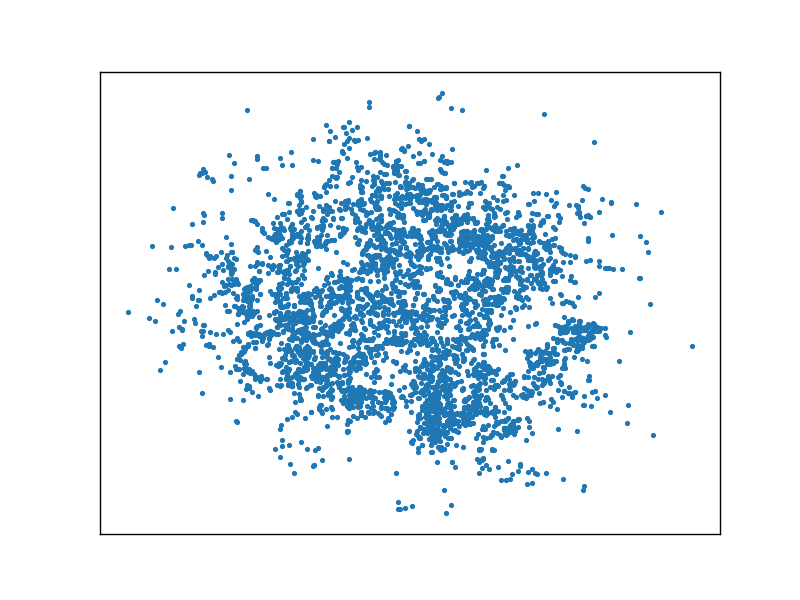

<IPython.core.display.Javascript object>


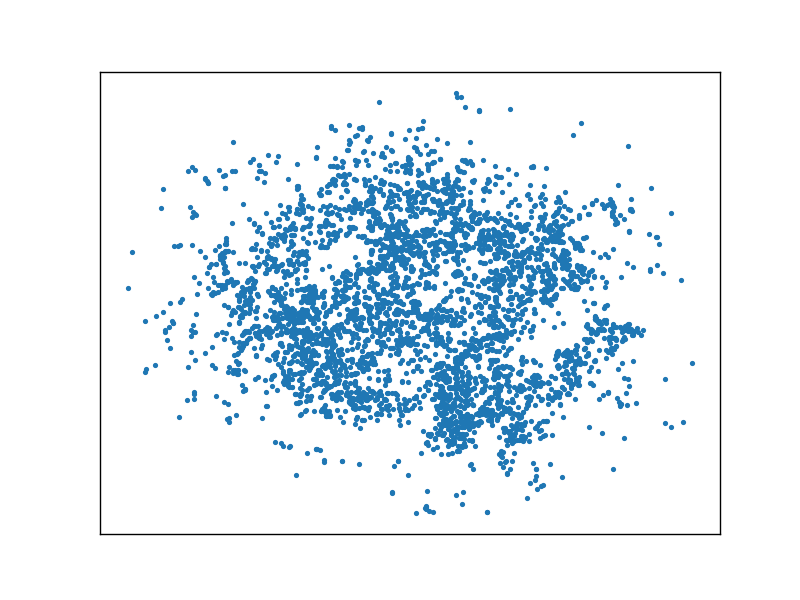

<IPython.core.display.Javascript object>


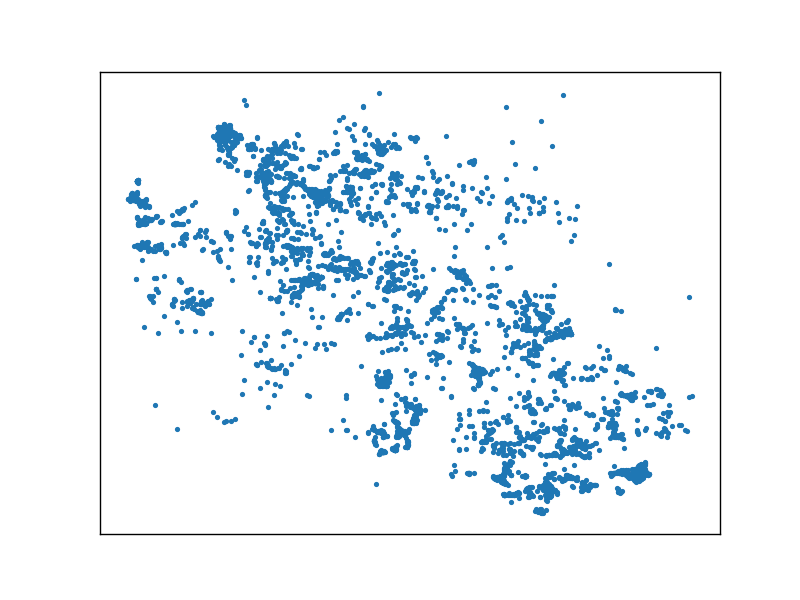

<IPython.core.display.Javascript object>


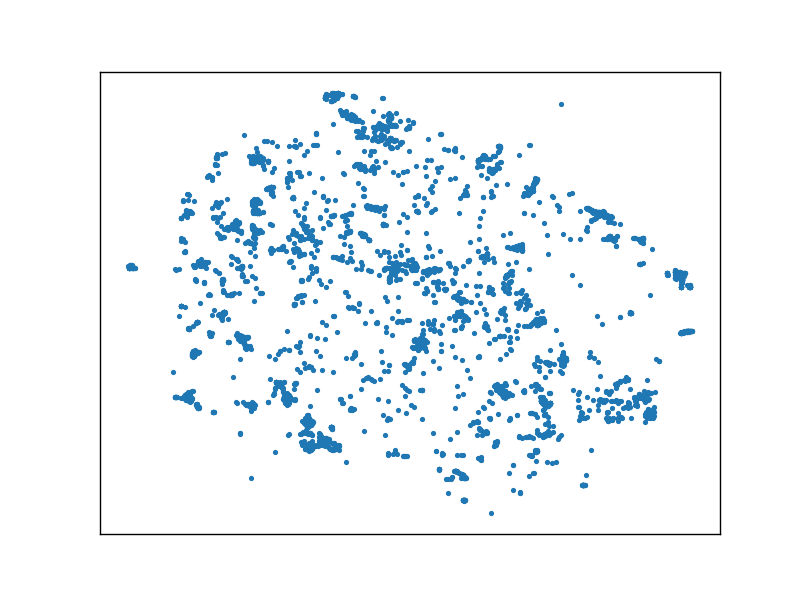

<IPython.core.display.Javascript object>


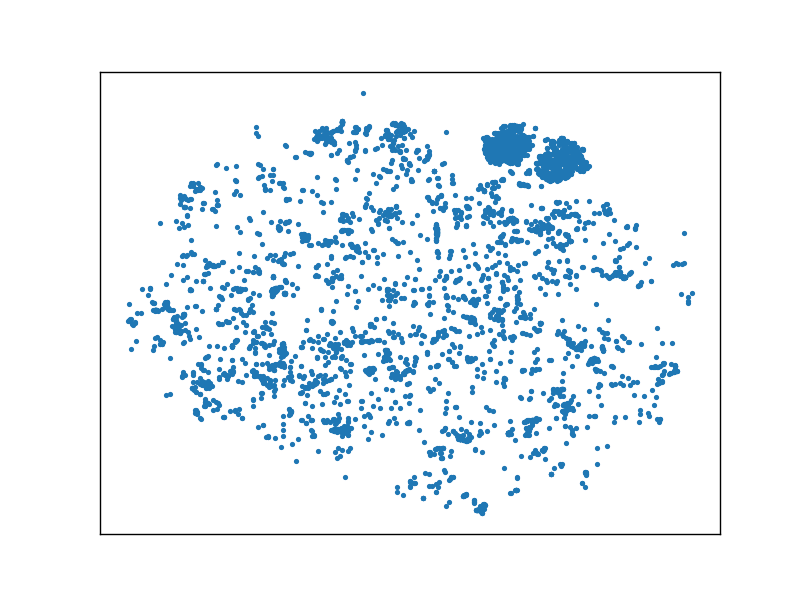

<IPython.core.display.Javascript object>


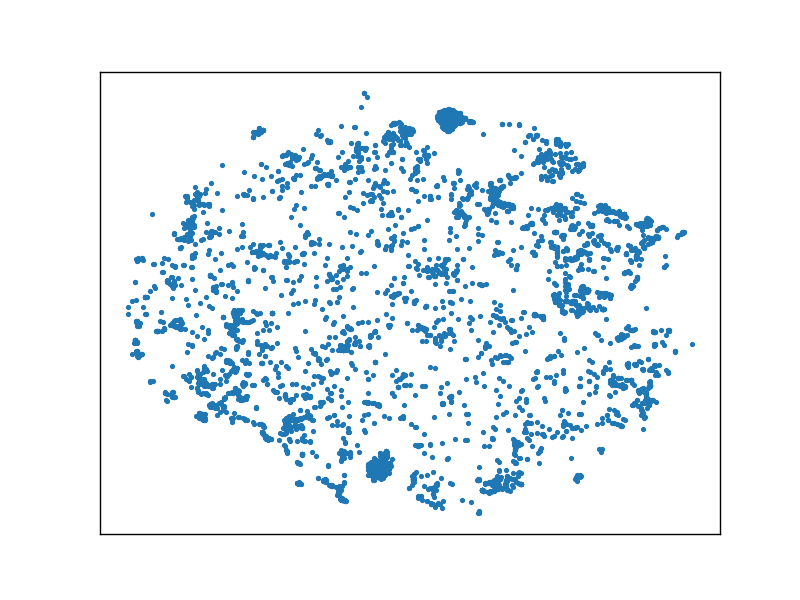

<IPython.core.display.Javascript object>


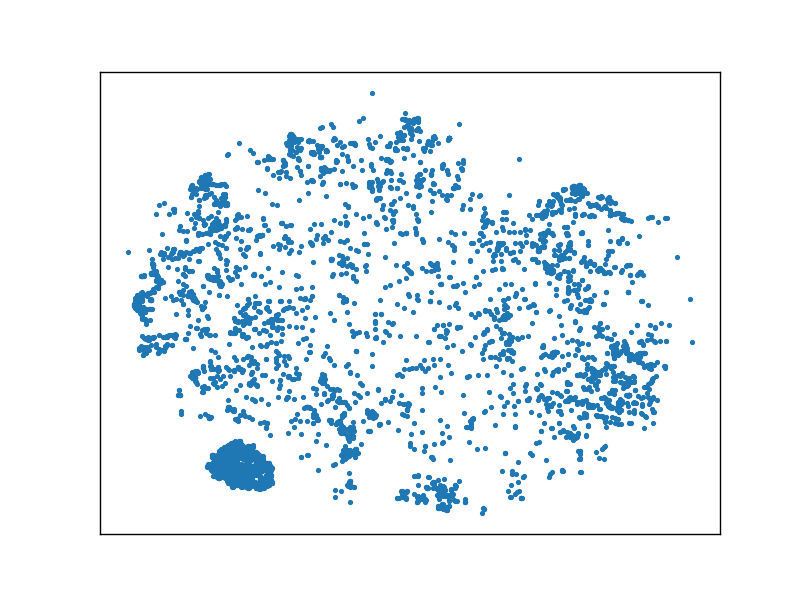

<IPython.core.display.Javascript object>


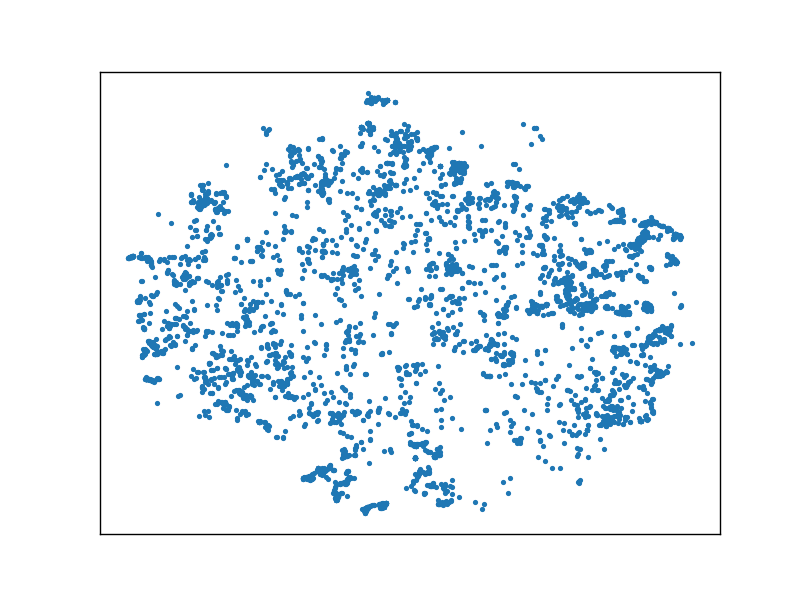

In [17]:
# plt.figure()
# plt.scatter(X_2d[:,0], X_2d[:,1])
ep_len = 5000
for ep in range(8):
    plt.figure()
    plt.scatter(X_2d[ep*ep_len:(ep+1)*ep_len,0], X_2d[ep*ep_len:(ep+1)*ep_len, 1],s=4)
    
    plt.xticks([])
    plt.yticks([])
    plt.show()
# plt.legend(['Day 1', 'Day 2', 'Day 3', 'Day 4'])
# plt.title('t-SNE action embedding vectors of SARA')
# plt.savefig('./figures/SARA_action_pie_plots/t_SNE_action_embedding_vectors_of_SARA.jpg',
#          dpi=300, bbox_inches='tight', pad_inches=0)